In [1]:
!gdown -q 1T6-AojJ-2ZwCR4X_SMeA5xmek7JLtolv
!unzip -q TruckDataset.zip

In [ ]:
!pip -q install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 914.9/914.9 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 47.1 MB/s eta 0:00:00


In [2]:
import os
import cv2
import torch
import numpy as np
import random
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import torch.nn as nn
import torch.optim as optim
from ultralytics import YOLO

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset_path = "/content/Dataset/"

In [10]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def read_image(img_path, yolo=False):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (640,640))
    if yolo:
        return img
    img = img / 255.
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    img = transform(img)
    img = img.to(torch.float32)
    img = img.to(device)
    return img

def make_prediction(model, img):
    # if type(model) == YOLO:
    #     results = model.predict(img, save=False, verbose=False)
    #     return len(results[0].boxes)

    with torch.no_grad():
        outputs = model(img.unsqueeze(0))
        return outputs[0][0].item()


def evaluate(model, yolo=False):
    model.eval()
    y_true = []
    y_pred = []
    y_original_pred = []
    print("Real value - Rounded prediction - Original prediction")
    with open(dataset_path+"/test/number_of_axles_test.txt", 'r') as f:
        for i in f.readlines():
            img_path, label = i.split(",")
            label = int(label)

            y_true.append(label)

            img = os.path.join(dataset_path+"test/images", img_path)
            if not yolo:
                img = read_image(img)

            prediction = make_prediction(model, img)
            y_original_pred.append(prediction)
            round_prediction = round(prediction)
            y_pred.append(round_prediction)

            if round_prediction != label:
                print(f"{label}: {round_prediction} - {prediction}")

    precision, recall, f1score, _ = precision_recall_fscore_support(y_true, y_pred, average="macro")
    accuracy = accuracy_score(y_true, y_pred)

    print("")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1score}")
    print(f"Accuracy: {accuracy}")

    # Calculando a Loss
    y_true_tensor = torch.tensor(y_true, dtype=torch.float32)
    y_original_pred_tensor = torch.tensor(y_original_pred, dtype=torch.float32)

    criterion = nn.MSELoss()
    loss = criterion(y_original_pred_tensor, y_true_tensor).item()

    mae = nn.L1Loss()
    mae_loss = mae(y_original_pred_tensor, y_true_tensor).item()

    print(f"Loss: {loss}")
    print(f"MAE Loss: {mae_loss}")


# Inception

In [ ]:
class InceptionModel(nn.Module):
    def __init__(self):
        super(InceptionModel, self).__init__()

        self.model = models.inception_v3(weights=models.Inception_V3_Weights.IMAGENET1K_V1)
        self.model.aux_logits = False

        self.model.fc = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        x = self.model(x)
        return x

inception = InceptionModel()
inception = inception.to(device)
inception.load_state_dict(torch.load("inception.pth"))

<All keys matched successfully>

In [ ]:
evaluate(inception)

Real value - Rounded prediction - Original prediction
7: 6 - 5.939828872680664
5: 4 - 4.160600662231445
3: 4 - 3.6044270992279053
3: 2 - 2.1354317665100098
4: 3 - 3.13653826713562
6: 5 - 4.732194423675537
7: 6 - 6.214473724365234
4: 2 - 2.3342432975769043

Precision: 0.8796660532167778
Recall: 0.8519126854233238
F1 Score: 0.8613615476518702
Accuracy: 0.926605504587156
Loss: 0.11837240308523178
MAE Loss: 0.2229844480752945


# ResNet

In [6]:
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        self.model = models.resnet152(weights=(models.ResNet152_Weights.IMAGENET1K_V1))

        self.model.fc = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        x = self.model(x)
        return x

resnet = ResNet()
resnet = resnet.to(device)
resnet.eval()
resnet.load_state_dict(torch.load("resnet.pth"))


<ipython-input-6-54e50464e7b8>:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet.load_state_dict(torch.load("resnet.pth"))


<All keys matched successfully>

In [11]:
evaluate(resnet)

Real value - Rounded prediction - Original prediction
7: 6 - 6.328249931335449
3: 4 - 3.576902151107788
3: 4 - 3.5589256286621094
3: 4 - 3.5243029594421387
3: 4 - 3.6496164798736572
3: 2 - 2.169822931289673
4: 3 - 3.399062156677246
6: 5 - 4.895577430725098
6: 5 - 5.38521671295166
4: 3 - 2.8354666233062744

Precision: 0.853077478077478
Recall: 0.8661522874288831
F1 Score: 0.854937154348919
Accuracy: 0.908256880733945
Loss: 0.09830203652381897
MAE Loss: 0.23534142971038818


# Yolo

In [ ]:
yolo = YOLO("best.pt")

In [ ]:
evaluate(model=yolo, yolo=True)

Real value - Rounded prediction - Original prediction
2: 3 - 3
2: 4 - 4
3: 4 - 4
4: 5 - 5

Precision: 0.9280778323331514
Recall: 0.9497872340425532
F1 Score: 0.9373882441435634
Accuracy: 0.963302752293578
Loss: 0.06422018259763718
MAE Loss: 0.0458715595304966


In [ ]:
metrics = yolo.val(data="Dataset/teste.yaml")

Ultralytics 8.3.70 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)


100%|██████████| 755k/755k [00:00<00:00, 18.7MB/s]
val: Scanning /content/Dataset/test/labels... 109 images, 0 backgrounds, 0 corrupt: 100%|██████████| 109/109 [00:00<00:00, 1092.73it/s]

val: New cache created: /content/Dataset/test/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.08it/s]


                   all        109        398      0.994      0.995      0.995       0.77
Speed: 4.5ms preprocess, 25.5ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/val2


In [ ]:
print(f"mAP50-95 : {metrics.box.map}")
print(f"mAP50    : {metrics.box.map50}")
print(f"mAP75    : {metrics.box.map75}")
print(f"Precision: {metrics.box.p[0]}")
print(f"Recall   : {metrics.box.r[0]}")
print(f"F1 Score : {metrics.box.f1[0]}")


mAP50-95 : 0.7700400536318341
mAP50    : 0.994899115832326
mAP75    : 0.9399364363157161
Precision: 0.9944383623267529
Recall   : 0.9949748743718593
F1 Score : 0.9947065460050668


# Making Predictions


In [18]:
import matplotlib.pyplot as plt

In [13]:
images_path = [
    "20160927102749_color-[ROI-1]-1.jpg",
    "20170418074140-550_color-[ROI-1]-30.jpg",
    "20170418095402_color-[ROI-1]-94.jpg"
]

In [16]:
def make_list_of_predictions(model):
    for path in images_path:
        #img = read_image(path, yolo = (type(model) == YOLO))
        img = read_image(path, False)
        prediction = make_prediction(model, img)
        print(prediction, round(prediction))

        plt.figure()
        plt.imshow(plt.imread(path))
        plt.axis("off")
        plt.show()

## Inception

5.948429107666016 6


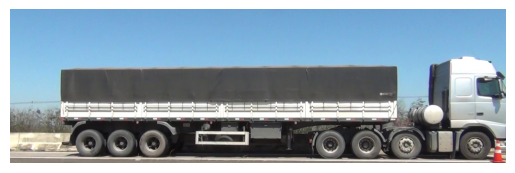

5.799472808837891 6


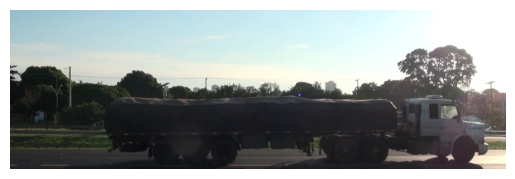

3.75557804107666 4


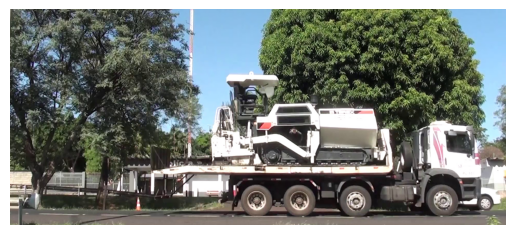

In [ ]:
make_list_of_predictions(inception)

## ResNet

6.296389579772949 6


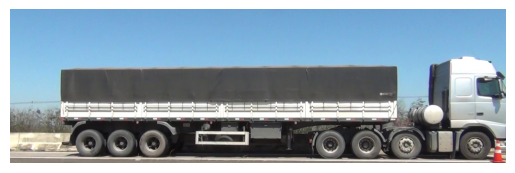

5.71120023727417 6


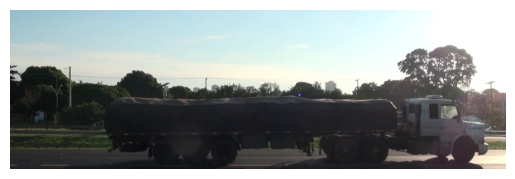

4.0096755027771 4


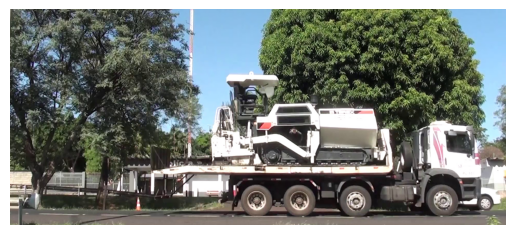

In [19]:
make_list_of_predictions(resnet)

## Yolo

In [ ]:
def make_yolo_prediction(model, img_path):
    original_img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    original_height, original_width, _ = original_img.shape

    img_resized = cv2.resize(original_img, (640, 640))
    results = model.predict(img_resized, save=False)

    print(f"Total number of axles: {len(results[0].boxes)}")
    for box in results[0].boxes:
        cords = box.xyxy[0].tolist()
        cords = [round(x) for x in cords]
        class_item = results[0].names[box.cls[0].item()]
        confidence = round(box.conf[0].item(), 2)

        # Scale coordinates back to original image size
        x1, y1, x2, y2 = cords
        x1 = int(x1 * (original_width / 640))
        y1 = int(y1 * (original_height / 640))
        x2 = int(x2 * (original_width / 640))
        y2 = int(y2 * (original_height / 640))

        # Draw bounding box on the image
        color = (255, 0, 0)
        cv2.rectangle(original_img, (x1, y1), (x2, y2), color, 3)

        # Adding the class and confidence on each prediction
        text = f"{class_item} {confidence:.2f}"
        (tw, th), _ = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.8, 2)
        cv2.rectangle(original_img, (x1, y1 - th - 5), (x1 + tw + 5, y1), color, -1)
        cv2.putText(original_img, text, (x1 + 2, y1 - 2), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 0), 2)

    print(original_img.shape)

    plt.figure()
    plt.imshow(original_img)
    plt.axis("off")
    plt.show()

    original_img = cv2.cvtColor(original_img, cv2.COLOR_RGB2BGR)
    cv2.imwrite("yolo_output_"+img_path, original_img)


Total number of axles: 7
(596, 1920, 3)


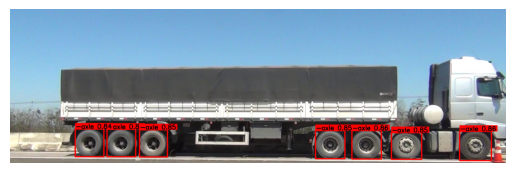

Total number of axles: 6
(616, 1920, 3)


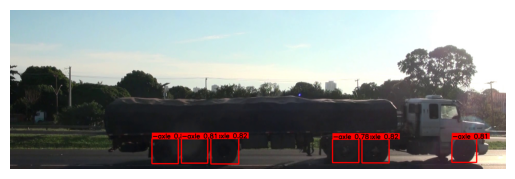

Total number of axles: 4
(836, 1920, 3)


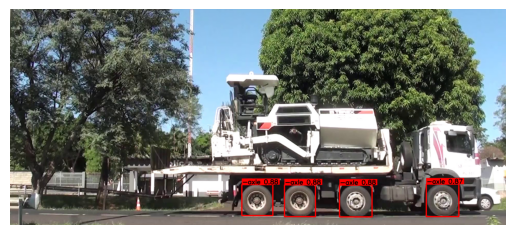

In [ ]:
for img in images_path:
    make_yolo_prediction(yolo, img)